In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
from ase.io import read
import numpy as np
import torch
from mlelec.utils.twocenter_utils import fix_orbital_order, _to_blocks, _to_coupled_basis, _to_matrix, _to_uncoupled_basis

In [5]:
ethorbs = {6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]],
1: [[1,0,0],[2,0,0],[2,1,1], [2,1,-1],[2,1,0]]
}
ethframe = read('examples/data/periodic/ethene/ethene.xyz') 
ethfock = np.load('examples/data/periodic/ethene/fock_ethene.npy')
ethoverlap = np.load('examples/data/periodic/ethene/over_ethene.npy')
ethfock  = fix_orbital_order(ethfock, ethframe, ethorbs)


# We must pass UNFIXED fock matrix to the MLDataset  <<<<<<<<<<<<<

blocks = _to_blocks(ethfock, ethframe, ethorbs)
coupled = _to_coupled_basis(blocks, ethorbs)



# THESE ARE UNFIXED 

In [6]:
btype = 0
n1, l1, n2, l2 = 2, 1, 3, 2
block=blocks.block(block_type = btype, n_i = n1, l_i = l1, n_j = n2, l_j = l2)

In [7]:
print(block.samples)
print()
print(block.values.shape)

Labels(
    structure  center  neighbor
        0        0        0
        0        1        1
)

torch.Size([2, 3, 5, 1])


In [8]:
L=2
block_coupled=coupled.block(block_type = btype, n_i = n1, l_i = l1, n_j = n2, l_j = l2,L=L)

In [9]:
print(block_coupled.samples)
print()
print(block_coupled.values)

Labels(
    structure  center  neighbor
        0        0        0
        0        1        1
)

tensor([[[-1.4794e-02],
         [-8.1845e-17],
         [-6.4607e-17],
         [-5.5151e-17],
         [-1.0181e-16]],

        [[ 1.4794e-02],
         [-1.0477e-17],
         [ 8.2890e-17],
         [ 1.7136e-16],
         [ 1.6368e-18]]])


In [10]:
coupled

TensorMap with 129 blocks
keys: block_type  species_i  n_i  l_i  species_j  n_j  l_j  L
          0           6       1    0       6       1    0   0
          0           6       1    0       6       2    0   0
                               ...
          1           1       2    1       1       2    1   2
          -1          1       2    1       1       2    1   1

In [11]:
def check_target(coupled_blocks, tol=1e-4):
    for k, b in coupled_blocks.items():
        btype= k['block_type']
        L = k['L']
        l1 = k['l_i']
        l2 = k['l_j']
        n1 = k['n_i']
        n2 = k['n_j']
        if L%2==0 and btype==-1 and (n1==n2) and (l1==l2):
            assert torch.norm(b.values)<=tol, f'btype {btype} L{L} failed - Block norm {torch.norm(b.values)}'
        elif L%2==1 and btype==1 and (n1==n2) and (l1==l2):
            assert torch.norm(b.values)<=tol, f'btype {btype} L{L} failed - Block norm {torch.norm(b.values)}'
        # elif s==-1:
        #     if L%2==0 and btype==1:
        #         assert torch.norm(b.values)<=tol, f'btype {btype} L{L} sigma{s} failed - Block norm {torch.norm(b.values)}'
        #     elif L%2==1 and btype==-1:
        #         assert torch.norm(b.values)<=tol, f'btype {btype} L{L} sigma{s} failed - Block norm {torch.norm(b.values)}'
        # else:
        #     print('error', li, l2, L, s)
# for k, b in target_coupled_blocks[name].items():
#     print(k, torch.norm(b.values))
check_target(coupled)

In [13]:
# for k,b in coupled.items():
#     print(k, torch.norm(b.values))

In [14]:
from mlelec.features.acdc import single_center_features, pair_features, twocenter_hermitian_features

/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [15]:
hypers = {'cutoff': 4.0, 
          'max_radial': 6, 
          'max_angular': 2,
           'atomic_gaussian_width':0.6,
          'center_atom_weight':1,
          "radial_basis": {"Gto": {}},
          "cutoff_function": {"ShiftedCosine": {"width": 0.1}}, }

In [16]:
rhoij = pair_features(ethframe, hypers= hypers,order_nu = 1, lcut=4)
gij = pair_features(ethframe, hypers= hypers,order_nu = 1, lcut=4,return_rho0ij=True)
rhoi = single_center_features(ethframe, hypers= hypers,order_nu = 2, lcut=4, feature_names = rhoij.property_names)#.to(dtype=torch.float32)

In [17]:
rhoi[0].values, gij[0].values

(tensor([[[8.4708e-01, 4.9243e-01, 3.6433e-01,  ..., 6.6816e-03,
           2.3294e-03, 5.7654e-04]],
 
         [[8.4708e-01, 4.9243e-01, 3.6433e-01,  ..., 6.6816e-03,
           2.3294e-03, 5.7654e-04]],
 
         [[8.4708e-01, 4.9243e-01, 3.6433e-01,  ..., 6.6816e-03,
           2.3294e-03, 5.7654e-04]],
 
         [[8.4708e-01, 4.9243e-01, 3.6433e-01,  ..., 6.6816e-03,
           2.3294e-03, 5.7654e-04]]]),
 tensor([[[ 8.7886e-01,  4.6945e-01,  7.7801e-02,  3.1722e-02,  1.3307e-03,
           -7.6962e-04]],
 
         [[ 4.0176e-02,  6.4406e-02,  2.5014e-01,  1.8195e-01,  4.9607e-02,
            1.1251e-02]],
 
         [[ 4.3305e-03, -2.6896e-03,  7.4717e-02,  2.0000e-01,  1.1163e-01,
            3.3424e-02]],
 
         [[-3.0015e-03,  3.8786e-03, -6.8002e-03,  8.3822e-02,  1.5778e-01,
            7.2135e-02]],
 
         [[ 4.0176e-02,  6.4406e-02,  2.5014e-01,  1.8195e-01,  4.9607e-02,
            1.1251e-02]],
 
         [[ 8.7886e-01,  4.6945e-01,  7.7801e-02,  3.1722e-02,  

In [18]:
from metatensor import Labels, TensorBlock, TensorMap
gijblock = []
for k,b in gij.items():
    gijblock.append( TensorBlock(
                        values = b.values, 
                        components = b.components, 
                        properties = b.properties, 
                        samples = Labels(b.samples.names[:3], values = b.samples.values[:,:3])
        
    ))

gij = TensorMap(gij.keys, gijblock)

In [19]:
import metatensor

In [20]:
hfeat = twocenter_hermitian_features(rhoi, rhoij)

In [21]:
hfeat = metatensor.remove_dimension(hfeat, axis="keys", name="cell_shift_a")
hfeat = metatensor.remove_dimension(hfeat, axis="keys", name="cell_shift_b")
hfeat = metatensor.remove_dimension(hfeat, axis="keys", name="cell_shift_c")
hfeat = metatensor.remove_dimension(hfeat, axis="keys", name="cell_shift_a_MIC")
hfeat = metatensor.remove_dimension(hfeat, axis="keys", name="cell_shift_b_MIC")
hfeat = metatensor.remove_dimension(hfeat, axis="keys", name="cell_shift_c_MIC")


In [23]:
for k,b in hfeat.items():
    L = k['spherical_harmonics_l']
    if k['block_type']==1 or k['block_type']==-1:
        # print(k.values, np.array([-1*k['block_type']]+k.values[1:].tolist() ]))
        mkey = Labels(k.names, np.array([k.values[:-1].tolist() +[-1*k['block_type']] ]))
        mb = hfeat.block(mkey)
        if ((L%2 == 1 and k['block_type'] == 1) or (L%2 == 0 and k['block_type'] == -1) )and k['inversion_sigma']==1:
            assert torch.norm(b.values) ==0, (L, k, torch.norm(b.values), '+' )
        elif ((L%2 == 1 and k['block_type'] == -1) or (L%2 == 0 and k['block_type'] == 1)) and k['inversion_sigma']==1:
            assert torch.norm(mb.values) ==0, (L, k, torch.norm(mb.values), '-' )

        
        elif ((L%2 == 1 and k['block_type'] == -1) or (L%2 == 0 and k['block_type'] == 1) )and k['inversion_sigma']==-1:
            assert torch.norm(b.values) ==0, (L, k, torch.norm(b.values), '+' )
        elif ((L%2 == 1 and k['block_type'] == 1) or (L%2 == 0 and k['block_type'] == -1)) and k['inversion_sigma']== -1:
            assert torch.norm(mb.values) ==0, (L, k, torch.norm(mb.values), '-' )

        
        else:
            print('s<ah,jfbvaekugdfsuiyhg')

AssertionError: (1, LabelsEntry(order_nu=2, inversion_sigma=1, spherical_harmonics_l=1, species_center=1, species_neighbor=1, block_type=1), tensor(0.9504), '+')

In [89]:
block_type = 1
n1,l1,n1,l2 = 1,0,2,1
L=0
inversion_sigma = 1
b = hfeat.blocks(block_type=block_type, spherical_harmonics_l=L, inversion_sigma=inversion_sigma)[0]#.values
mb  = hfeat.blocks(block_type=-1*block_type, spherical_harmonics_l=L, inversion_sigma=inversion_sigma)[0]#.values

In [90]:
b.samples

Labels(
    structure  center  neighbor
        0        2        3
        0        2        4
        0        2        5
        0        3        4
        0        3        5
        0        4        5
)

In [91]:
b.values[0]

tensor([[0.0568, 0.0911, 0.3537, 0.2573, 0.0702, 0.0159]], dtype=torch.float64)

In [92]:
mb.values[0]

tensor([[0., 0., 0., 0., 0., 0.]], dtype=torch.float64)

In [13]:
from mlelec.models.linear import LinearTargetModel
from mlelec.data.dataset import MoleculeDataset, MLDataset

In [14]:
eth_data = MoleculeDataset(mol_name="ethene", 
                           frames = [ethframe], 
                           
                           target_data=
                           {"fock":torch.from_numpy(ethfock).reshape(1, *ethfock.shape),
                            },
                            orbs="def2svp",
                            aux_data={"orbitals":ethorbs,
                                      "overlap": ethoverlap })
ml_data = MLDataset(molecule_data = eth_data, 
                    features = hfeat, 
                    shuffle=False,
                    model_strategy = "coupled",
                    )

In [15]:
species = 6
L = 2
sigma = -1
rhoiblock = rhoi.block(spherical_harmonics_l = L, species_center = species, inversion_sigma = sigma)

In [16]:
print(rhoiblock.samples)
print()
print(rhoiblock.values)

Labels(
    structure  center
        0        0
        0        1
)

tensor([[[-0.0251, -0.0589, -0.0853,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0251,  0.0589,  0.0853,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]])


Inversion sigma is really important to match the target behavior to the features
For example 2p-3d L=1, L=2 targets have a different sign for C1-C1 vs C2-C2

In [17]:
model = LinearTargetModel(ml_data)

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, patience=20, verbose=True
)
import mlelec.metrics as mlmetrics

loss_fn = getattr(mlmetrics, "L2_loss") # Loss function is the L2 loss 
losses = []
early_stop_count = 0
nepochs = 800

In [19]:
from mlelec.data.dataset import get_dataloader
ml_data._split_indices(train_frac=1.0, val_frac=0.0, test_frac=0.0)
train_dl, val_dl, test_dl = get_dataloader(ml_data, model_return="blocks") # instantiate dataloaders to return the coupled blocks

In [20]:
for epoch in range(nepochs):
    model.train(True)
    train_loss = 0
    for i, data in enumerate(train_dl):
        optimizer.zero_grad()
        pred = model(data["input"], return_type="coupled_blocks", batch_indices=data["idx"])  
        loss = loss_fn(pred, data["output"])
        train_loss += loss
        loss.backward()
        optimizer.step()
    losses.append(train_loss.item())
    # scheduler.step(train_loss)



        # val_loss = loss_fn(torch.cat(val_pred), torch.cat(val))
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, train loss {train_loss/len(ml_data.train_idx)}")

        # print(f"Epoch {epoch} val loss {val_loss/len(ml_data.val_idx)}")

Epoch 0, train loss 418.4944763183594
Epoch 10, train loss 334.0411682128906
Epoch 20, train loss 266.82220458984375
Epoch 30, train loss 211.9429473876953
Epoch 40, train loss 168.40927124023438
Epoch 50, train loss 133.489990234375
Epoch 60, train loss 103.20378875732422
Epoch 70, train loss 75.93745422363281
Epoch 80, train loss 52.22489547729492
Epoch 90, train loss 32.97823715209961
Epoch 100, train loss 18.74751091003418
Epoch 110, train loss 9.378336906433105
Epoch 120, train loss 4.022314548492432
Epoch 130, train loss 1.4446722269058228
Epoch 140, train loss 0.44128701090812683
Epoch 150, train loss 0.14232543110847473
Epoch 160, train loss 0.07764691114425659
Epoch 170, train loss 0.06322343647480011
Epoch 180, train loss 0.05259237438440323
Epoch 190, train loss 0.04199056699872017
Epoch 200, train loss 0.033397722989320755
Epoch 210, train loss 0.027092618867754936
Epoch 220, train loss 0.022415271028876305
Epoch 230, train loss 0.01878647319972515
Epoch 240, train loss 0.0

KeyboardInterrupt: 

In [21]:
pred = model.forward(hfeat, return_type="coupled_blocks")

In [22]:
from mlelec.utils.plot_utils import plot_block_errors

In [23]:
coupled[0].values

tensor([[[-11.2317]],

        [[-11.2317]]])

In [24]:
for k, b in data["output"].items():
    eq= b.samples==coupled.block(k).samples
    if not eq:
        raise ValueError(f"Samples are not the same for block {k}")
    norm = torch.linalg.norm(b.values-coupled.block(k).values)
    if norm > 1e-10:
        
        print(b.values)
        print()
        print(coupled.block(k).values)
        break

tensor([[[-1.3245e-16],
         [-2.8418e-04],
         [-2.5784e-17]],

        [[ 7.6762e-17],
         [ 2.8418e-04],
         [ 4.8384e-18]]])

tensor([[[-2.5784e-17],
         [-1.3245e-16],
         [-2.8418e-04]],

        [[ 4.8384e-18],
         [ 7.6762e-17],
         [ 2.8418e-04]]])


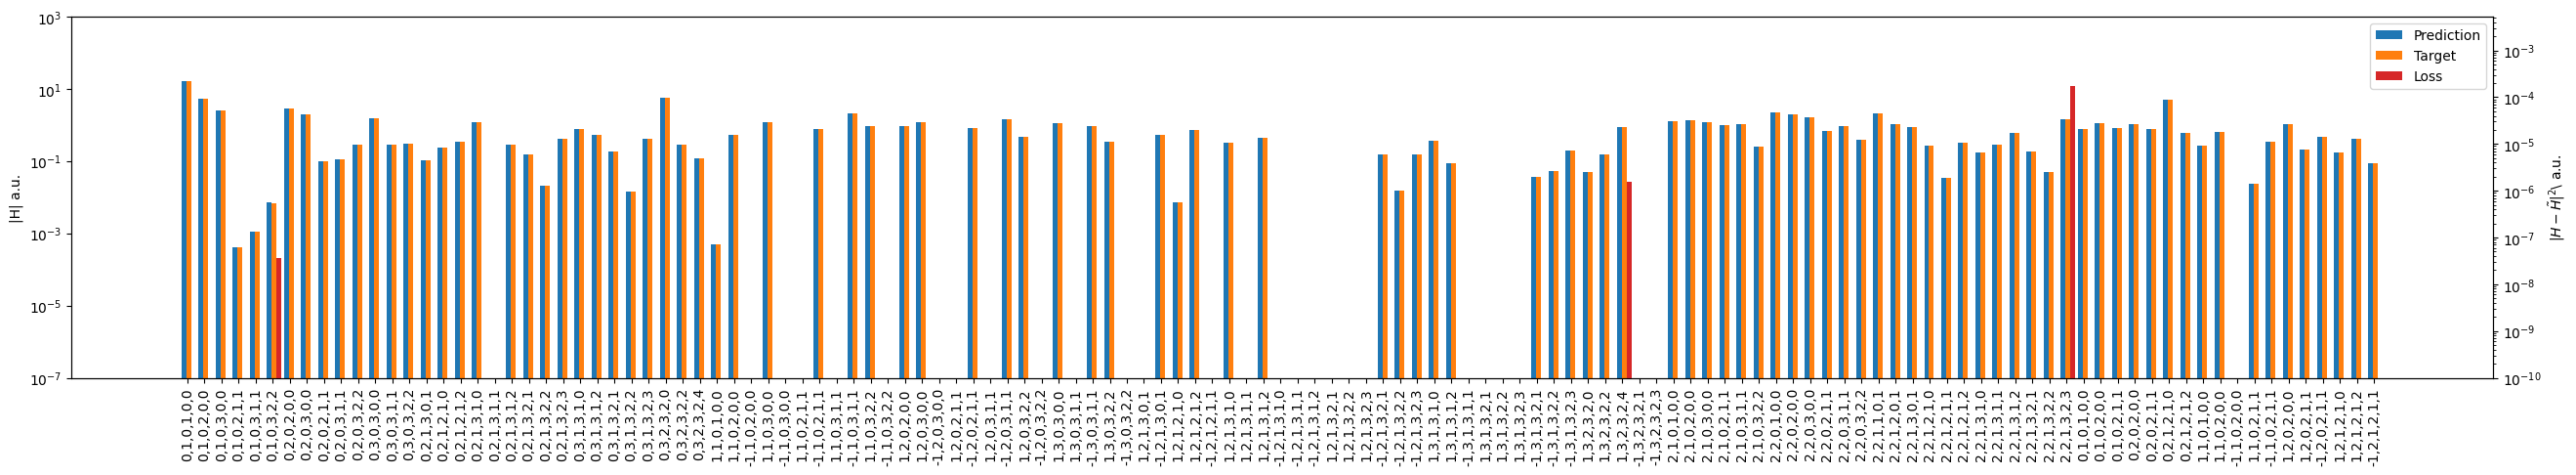

In [30]:
plot_block_errors(pred, data["output"], plot_loss=True)